### Downloading and Exploring the Data

In [3]:
#Downloading the data from kaggle and storing it in tmp folder
!wget --no-check-certificate \
    "https://storage.googleapis.com/kaggle-data-sets/111880/269359/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1576939806&Signature=kCGxjvm7CKYTbuSQs4O923gGKUE8wvANdBz5Nx%2BelqBlNBYceBnLqaQiGBv2ut53nrr4xaB3tnTJY1Fhq4ahYsihTRu0IvGy14L9RPFf5CUo9tlp1oNbEpqclx8mK5rRxeGEzgt2uwN8%2Bc40EAuOf0NrVfGwB%2BCieX%2FtvGaH6Z%2BcAak1zBfPXE75%2B6RmeMrm8u1XkbqDaJhWr9oVW6d9u2uZ%2B89%2FVewgp4DZ%2FtsZXIW4RFMEYaSmzRfJlVUYBZ%2Fs6MIJuPT8gu0ckkpa63WzsjrZc7ggdP2qKPulRHMDXxwk40NkCXIaKyWKaNxoiTkiOLaxIZnYWGgbBLLiEU8yuA%3D%3D&response-content-disposition=attachment%3B+filename%3Dintel-image-classification.zip" \
    -O "/tmp/Data.zip"

--2019-12-19 05:05:44--  https://storage.googleapis.com/kaggle-data-sets/111880/269359/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1576939806&Signature=kCGxjvm7CKYTbuSQs4O923gGKUE8wvANdBz5Nx%2BelqBlNBYceBnLqaQiGBv2ut53nrr4xaB3tnTJY1Fhq4ahYsihTRu0IvGy14L9RPFf5CUo9tlp1oNbEpqclx8mK5rRxeGEzgt2uwN8%2Bc40EAuOf0NrVfGwB%2BCieX%2FtvGaH6Z%2BcAak1zBfPXE75%2B6RmeMrm8u1XkbqDaJhWr9oVW6d9u2uZ%2B89%2FVewgp4DZ%2FtsZXIW4RFMEYaSmzRfJlVUYBZ%2Fs6MIJuPT8gu0ckkpa63WzsjrZc7ggdP2qKPulRHMDXxwk40NkCXIaKyWKaNxoiTkiOLaxIZnYWGgbBLLiEU8yuA%3D%3D&response-content-disposition=attachment%3B+filename%3Dintel-image-classification.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.112, 2607:f8b0:4007:80c::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 363152213 (346M) [application/zip]
Saving to: ‘/tmp/Data.zip’

/tmp/Data.zip       100%[========

In [0]:
from zipfile import ZipFile

# Unzipping the file and storing in /data
zip_dir = '/tmp/Data.zip'
zip_ref = ZipFile(zip_dir, 'r')
zip_ref.extractall('/data')
zip_ref.close()

In [5]:
#Printing the name of the classes of the data

import os
train_dir = '/data/seg_train/seg_train'
test_dir = '/data/seg_test/seg_test'

classes = os.listdir(train_dir)
print("The Classes of images are as follows: ")
print(', '.join(classes))

The Classes of images are as follows: 
forest, street, buildings, glacier, mountain, sea


forest


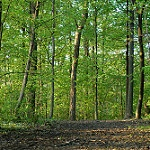


street


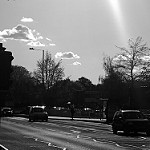


buildings


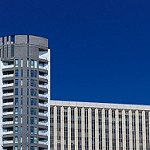


glacier


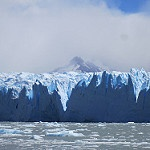


mountain


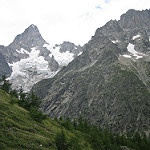


sea


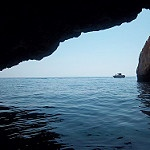

In [6]:
#Plotting one image from each class

import cv2
from google.colab.patches import cv2_imshow
for class_name in classes:
  img_path = os.listdir(os.path.join(train_dir, class_name))[0]
  img = cv2.imread(os.path.join(train_dir, class_name,img_path))
  print(class_name)
  cv2_imshow(img)
  print()

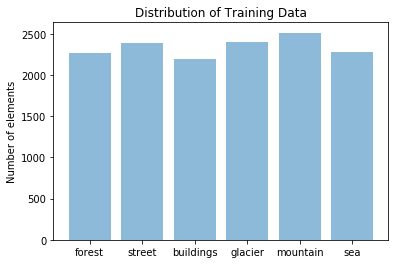

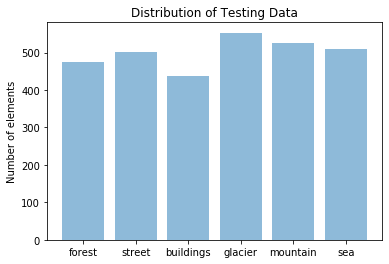

In [7]:
#Plotting the Distribution of each class of train and test set

import matplotlib.pyplot as plt
import numpy as np

y_pos = np.arange(len(classes))
train_class_num = []
test_class_num = []

for class_name in classes:
   train_class_num.append(len(os.listdir(os.path.join(train_dir,class_name))))
plt.bar(y_pos, train_class_num, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('Number of elements')
plt.title('Distribution of Training Data')
plt.show()

for class_name in classes:
   test_class_num.append(len(os.listdir(os.path.join(test_dir,class_name))))
plt.bar(y_pos, test_class_num, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('Number of elements')
plt.title('Distribution of Testing Data')
plt.show()

### Training the InceptionV3 network on the Data

In [8]:
#Using image data generator to load the data for training
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, decode_predictions

WIDTH=299
HEIGHT=299
BATCH_SIZE=64

#Train DataSet Generator with Augmentation
print("\nTraining Data Set")
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_flow = train_generator.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

#Test DataSet Generator with Augmentation
print("\nTest Data Set")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

Using TensorFlow backend.



Training Data Set
Found 14034 images belonging to 6 classes.

Test Data Set
Found 3000 images belonging to 6 classes.


In [9]:
#Loading the inceptionV3 model and adjusting last layers

from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
import tensorflow as tf

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(WIDTH, HEIGHT,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(train_flow.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False
  
model.compile(optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()














87916544/87910968 [==============================] - 3s 0us/step


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________

In [10]:
import math
top_layers_file_path="model.hdf5"

#Defining the callbacks for the model
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="loss", mode="min", patience=5)

#Training
history = model.fit_generator(train_flow, 
                              epochs=20, 
                              verbose=1,
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
220/220 [==============================] - 83s 378ms/step - loss: 0.4668 - acc: 0.8271

Epoch 00001: loss improved from inf to 0.46456, saving model to model.hdf5
Epoch 2/20
220/220 [==============================] - 74s 336ms/step - loss: 0.3061 - acc: 0.8874

Epoch 00002: loss improved from 0.46456 to 0.30614, saving model to model.hdf5
Epoch 3/20
220/220 [==============================] - 74s 335ms/step - loss: 0.2800 - acc: 0.8949

Epoch 00003: loss improved from 0.30614 to 0.28029, saving model to model.hdf5
Epoch 4/20
220/220 [==============================] - 74s 335ms/step - loss: 0.2575 - acc: 0.9040

Epoch 00004: loss improved from 0.28029 to 0.25685, saving model to model.hdf5
Epoch 5/20
220/220 [==============================] - 74s 335ms/step - loss: 0.2388 - acc: 0.9122

Epoch 00005: loss improved from 0.25685 to 0.23940, saving model to model.hdf5
Epoch 6/20
220/220

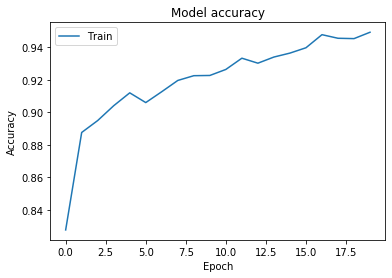

In [11]:
# Plot training accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

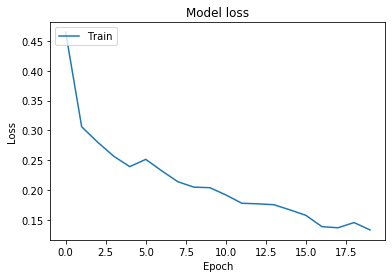

In [12]:
#Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Model Evaluation

In [13]:
#Loading the best saved model
#Tesing the model using the 'Test set'

model.load_weights(top_layers_file_path)
loss, acc = model.evaluate_generator(
    test_flow,
    verbose = True,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
print("Loss: ", loss)
print("Acc: ", acc)

47/47 [==============================] - 21s 455ms/step
Loss:  0.5929966271718343
Acc:  0.8259999995231628


The predicted label is: buildings
With confidence:  99.58 %


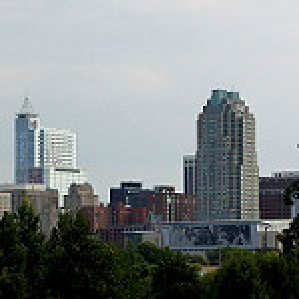

In [49]:
#Predicting the lable of 'Pred set' images

import random
from keras.preprocessing import image

labels = [k for k, _ in train_flow.class_indices.items()]

file_list = os.listdir('/data/seg_pred/seg_pred')
img_name = random.choice(file_list)
img_path = os.path.join('/data/seg_pred/seg_pred',img_name)

img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

pred = model.predict(x)
pred_label = labels[np.argmax(pred)]
print("The predicted label is:",pred_label)
print("With confidence: ", round(pred[0][np.argmax(pred)]* 100, 2),"%")
img